# Rolling forecasting PM2.5

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pm25_hyperparameters import *

data=pd.read_csv("BeijingPM_dataset.csv")
picker=pd.to_datetime(data["date"])
data.drop("date",axis=1,inplace=True)
data.head()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,...,precipitation_max,Iws_max,PM_max,TEMP_min,DEWP_min,HUMI_min,PRES_min,precipitation_min,Iws_min,PM_min
0,2010,1,3,0,4,63.0,-7.0,92.0,1027.0,-6.0,...,0.4,58.56,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
1,2010,1,3,1,4,65.0,-8.0,85.0,1026.0,-6.0,...,0.5,61.69,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,63.0
2,2010,1,3,2,4,55.0,-8.0,92.0,1026.0,-7.0,...,0.5,65.71,181.0,-14.0,-21.0,25.0,1014.0,0.0,0.89,55.0
3,2010,1,3,3,4,65.0,-8.0,92.0,1025.0,-7.0,...,0.7,68.84,181.0,-12.0,-20.0,25.0,1014.0,0.0,0.89,55.0
4,2010,1,3,4,4,83.0,-8.0,92.0,1024.0,-7.0,...,1.2,72.86,181.0,-10.0,-20.0,25.0,1014.0,0.0,0.89,55.0


In [51]:
x_met=["year","month","day","hour","season"]
y_met=list(set(prim_fea)-set(["PM"]))

datetime_cols=["is_holiday","is_special_event"]

x_pm=list(set(data.columns)-set(["PM"])-set(datetime_cols))

def fill_fea(pos,cols):
    for col in cols:
        lagtmp=[]
        for t in range(1,lag_hours+1):
            x=data.loc[pos-t,col]
            data.loc[pos,"%s_lag%d" % (col,t)]=x
            lagtmp.append(x)
        data.loc[pos,"%s_mean" % col]=np.mean(lagtmp)
        data.loc[pos,"%s_min" % col]=np.min(lagtmp)
        data.loc[pos,"%s_max" % col]=np.max(lagtmp)

# Column names for lagged features
for col in y_met:
    for t in range(1,lag_hours+1):
        x_met.append("%s_lag%d" % (col,t))
    for r in ["mean","max","min"]:
        x_met.append("%s_%s" % (col,r))
        
# Best parameters obtained via cross validation
pm_model_params={
    'objective': 'l2',
    'num_leaves': 64,
    'min_data_in_leaf': 20,
    'max_depth': 30,
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_freq': 50,
    'bagging_fraction': 1.0
}

In [57]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

def do_met(lowb):
    met_train=data[:lowb]
    met_test=data[lowb:lowb+24]
    met_model=MultiOutputRegressor(LGBMRegressor(random_state=101,objective="rmse",eval_metric="rmse"),n_jobs=4)
    met_model.fit(met_train[x_met],met_train[y_met])
    for k in tqdm(met_test.index,desc="[%d:%d] (1/2)" % (lowb,lowb+24)):
        fill_fea(k,y_met)
        data.loc[k,y_met]=pd.DataFrame(met_model.predict(met_test.loc[[k],x_met]),columns=y_met).loc[0]

def do_predict(lowb):
    do_met(lowb)
    pm_train=data[:lowb]
    pm_test=data[lowb:lowb+24]
    pm_control=LGBMRegressor(random_state=101,**pm_model_params)
    pm_control.fit(pm_train[x_pm],pm_train["PM"])
    pm_datetime=LGBMRegressor(random_state=101,**pm_model_params)
    pm_datetime.fit(pm_train[x_pm+datetime_cols],pm_train["PM"])
    pm_predict_control=[]
    pm_predict_datetime=[]
    for k in tqdm(pm_test.index,desc="[%d:%d] (2/2)" % (lowb,lowb+24)):
        fill_fea(k,["PM"])
        pm_predict_control.append(pm_control.predict(data.loc[[k],x_pm])[0])
        pm_predict_datetime.append(pm_datetime.predict(data.loc[[k],x_pm+datetime_cols])[0])
    return pd.DataFrame({"LightGBM":pm_predict_control,"LightGBM + holidays and special events":pm_predict_datetime})

In [59]:
boundary_idx=picker[picker=="2015-12-20 00:00:00"].index.tolist()[0]

pm_df_list=[]

print("Predicting PM2.5 for [%d:%d]" % (boundary_idx,data.shape[0]))

for t in reversed(range(boundary_idx,data.shape[0],24)):
    tmp=do_predict(t)
    pm_df_list.append(tmp)

pm_df_list.reverse()
pm_df=pd.concat(pm_df_list)
pm_df.index=range(boundary_idx,data.shape[0])

pm_comp=pd.concat([data.loc[pm_df.index,"PM"],pm_df],axis=1)

Predicting PM2.5 for [52248:52536]


[52248:52272] (2/2): 100%|██████████| 24/24 [00:11<00:00,  2.02it/s]


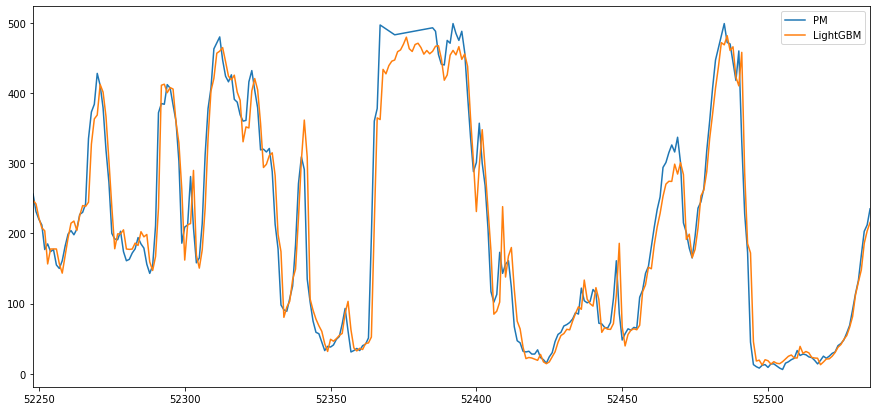

In [67]:
plt.figure(figsize=(15,7))
ax=plt.gca()
pm_comp[["PM","LightGBM"]].plot(ax=ax)

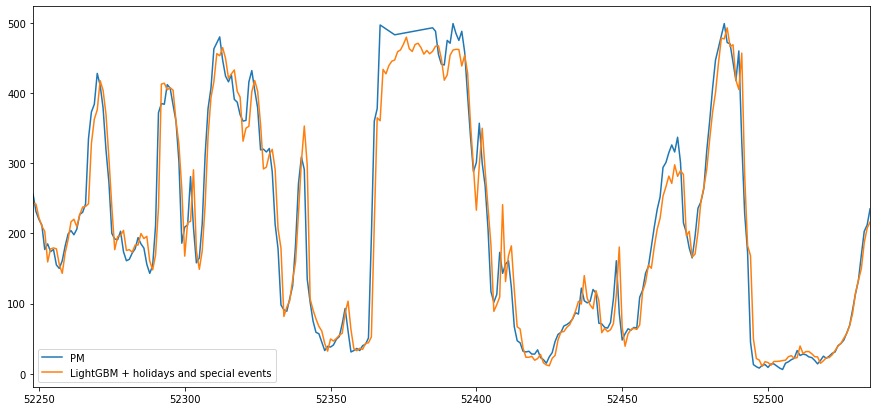

In [66]:
plt.figure(figsize=(15,7))
ax=plt.gca()
pm_comp[["PM","LightGBM + holidays and special events"]].plot(ax=ax)

## Evaluation metrics

After predicting PM2.5 concentration, we now begin analyzing the performance. In our study, we use three evaluation metrics to rank our model (let $y_i$ be the true value and $p_i$ be the predicted values).

$$
MAE=\frac1N\sum_{i=1}^N|y_i-p_i| \\
RMSE=\sqrt{\frac1N\sum_{i=1}^N(y_i-p_i)^2} \\
SMAPE=\frac1N\sum_{i=1}^N{|y_i-p_i|\over(|y_i|+|p_i|)/2}
$$

In [70]:
def get_mae(y,p):
    return abs(y-p).mean()

def get_rmse(y,p):
    return np.sqrt(np.square(y-p).mean())

def get_smape(y,p):
    return 100/len(y)*np.sum(2*abs(y-p)/(abs(y)+abs(p)+1e-7))

eval_metrics={"MAE":get_mae,"RMSE":get_rmse,"SMAPE":get_smape}

def pm_metrics(col,m):
    return eval_metrics[m](pm_comp["PM"],pm_comp[col])

pm_metrics={}

for m in eval_metrics.keys():
    pm_metrics[m]=[]

for col in pm_df.columns:
    for m in pm_metrics.keys():
        pm_metrics[m].append(eval_metrics[m](pm_comp["PM"],pm_comp[col]))

edf=pd.DataFrame(pm_metrics,index=pm_df.columns)
edf

,MAE,RMSE,SMAPE
LightGBM,23.530689,35.847293,16.173103
LightGBM + holidays and special events,23.406710,35.628127,16.256555
